In [1]:
#import sys; sys.path.append('../../'); 
import torch
from torch import nn
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load Model Parameters and Initial State

In [2]:
!pip install gdown && gdown --id 1qL3wFTM1KXC7V3JYPp9jSmh2gysOt5cz && unzip model.zip

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/urllib3/util/connection.py", line 73, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/socket.py", line 953, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/urlli

In [3]:
A_sys = torch.load("A_sys")
B_sys = torch.load("B_sys")
x0 = torch.load("x0")
pos_dict = torch.load("pos_dict")
dofs_dict = torch.load("dofs_dict")

### Finite Element Discretization Dynamics

The discretized model presents linear time-invariant dynamics

$$
    \dot z_t = A z_t + B u(z_t)
$$

with a 160-dimensional discretized state $z_t$ and *boundary* control policy $u_\partial$


In [4]:
class ControlledSystem(nn.Module):
    '''
        Boundary-controlled discretized linear port-hamiltonian system. 
        This is just a N-dimensional linear ODE: "dx/dt = Ax + Bu" where A and B are 
        the discretized infinite-dimensional operators, "x" 
        is the discretized state and "u" in the boundary control input.
    '''
    def __init__(self, A, B, u):
        super().__init__()
        self.A = A
        self.B = B
        self.u = u
        
    def forward(self, t, X): 
        dX = torch.einsum('ij, ...j->...i', A, X)
        dX = dX + torch.einsum('ij, ...j->...i', B, self.u(X))
        return dX

### Model with `MultipleShootingProblem`

In [6]:
import pytorch_lightning as pl
from numpy import pi

trainloader = dummy_trainloader()

x0 = torch.load('x0')[None].to(device).float()
x_dim, u_dim = x0.shape[1], 2

class MSLearner(pl.LightningModule):
    '''
        MSL training module for the PDE control experiment
    '''
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model # multiple shooting layer
        self.t = torch.linspace(0, 5, 500).to(device) # time span
        self.z0 = x0 # initial condition
        #_, self.zT = #odeint(self.model, self.z0, self.t, solver='rk4')#.detach() fine initialization of the solution
        self.zT = self.zT.detach()
        #print(self.zT)
        print(f"Initial seq. solution obatained with dopri5 ODE solver")
        
        self.flag = 0
        self.current_time = 0
        
    def forward(self, x, B0):
        return odeint_mshooting(self.model, x, self.t, solver='parareal', B0=B0, fine_steps=1, maxiter=1)
    
    def training_step(self, batch, batch_idx):      
        if not self.flag:
            self.current_time = time.time()
            self.flag = 1.        
        fw_time = time.time() - self.current_time
        self.current_time = time.time()
        
        zT = self(self.z0, B0=self.zT)
        print('dio')
        self.zT = zT.detach()
        
        control_loss = torch.norm(zT[:,0,dofs_dict['sig_t']], p=2, dim=-1).mean()
        control_loss = control_loss + torch.norm(zT[:,0,dofs_dict['sig_r']], p=2, dim=-1).mean()
        reg_loss = 1e-3 * self.model.vf.u(zT).abs().mean()
        loss = control_loss + reg_loss
        
        with torch.no_grad():
            self.logger.experiment.log(
                {
                    'control_loss': torch.clone(control_loss).cpu().detach(),
                    'reg_loss': torch.clone(reg_loss).cpu().detach(),
                    'train loss': torch.clone(loss).cpu().detach(),
                    'fw_time': fw_time
                }
            )
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train_dataloader(self):
        return trainloader

In [ ]:
A = torch.load('A_sys').to(device).float()
B = torch.load('B_sys').to(device).float()

import wandb
from pytorch_lightning.loggers import WandbLogger

hdim = 16
u = nn.Sequential(
    nn.Linear(x_dim, hdim),
    nn.Softplus(),
    nn.Linear(hdim, hdim),
    nn.Softplus(),
    nn.Linear(hdim, hdim),
    nn.Tanh(),
    nn.Linear(hdim, u_dim)).to(device)

for p in u[-1].parameters(): torch.nn.init.zeros_(p)

f = ControlledSystem(A, B, u).to(device)
t = torch.linspace(0, 5, 500).to(device)

learn = MSLearner(f)
wandb.init(project='mshooting-pde')
logger = WandbLogger(project='mshooting-pde', log_model=False)

trainer = pl.Trainer(max_epochs=2500, gradient_clip_val=.3, logger=logger)
trainer.fit(learn)

In [ ]:
t = torch.linspace(0, 5, 500)
xT = odeint(f.to(device), x0.to(device), t, method='rk4').detach().cpu()
uT = f.u(xT.to(device))

v_t = xT[:,0,dofs_dict['v_t']]
v_r = xT[:,0,dofs_dict['v_r']]
sig_t = xT[:,0,dofs_dict['sig_t']]
sig_r = xT[:,0,dofs_dict['sig_r']]

fig, axs = plt.subplots(3, 1, figsize=(10, 5))
axs[0].plot(t.cpu(), v_t, ':k');
axs[0].plot(t.cpu(), v_r, 'b');
axs[1].plot(t.cpu(), sig_t, ':k');
axs[1].plot(t.cpu(), sig_r, 'b');
axs[2].plot(t.cpu(), uT[:,0,:].detach().cpu(), ':b');

(-0.1, 0.1)

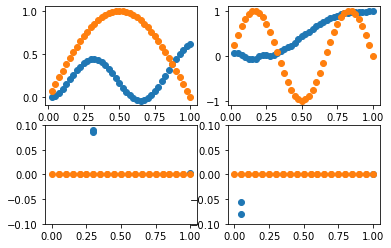

In [17]:
v_t = xT[:,0,dofs_dict['v_t']].cpu()
v_r = xT[:,0,dofs_dict['v_r']].cpu()
sig_t = xT[:,0,dofs_dict['sig_t']].cpu()
sig_r = xT[:,0,dofs_dict['sig_r']].cpu()

x_v_t = x_dict['v_t'].cpu()
x_v_r = x_dict['v_r'].cpu()
x_sig_t = x_dict['sig_t'].cpu()
x_sig_r = x_dict['sig_r'].cpu()

fig, axs = plt.subplots(2, 2)
axs[0,0].scatter(x_v_t, v_t[-1])
axs[0,1].scatter(x_v_r, v_r[-1])
axs[1,0].scatter(x_sig_t, sig_t[-1])
axs[1,1].scatter(x_sig_r, sig_r[-1])
axs[0,0].scatter(x_v_t, v_t[0])
axs[0,1].scatter(x_v_r, v_r[0])
axs[1,0].scatter(x_sig_t, sig_t[0])
axs[1,1].scatter(x_sig_r, sig_r[0])

axs[1,0].set_ylim([-.1, .1])
axs[1,1].set_ylim([-.1, .1])

In [18]:
from torchdyn.models import MultipleShootingProblem

In [19]:
A = torch.load('A_sys').to(device).float()
B = torch.load('B_sys').to(device).float()

import wandb
from pytorch_lightning.loggers import WandbLogger

hdim = 16
u = nn.Sequential(
    nn.Linear(x_dim, hdim),
    nn.Softplus(),
    nn.Linear(hdim, hdim),
    nn.Softplus(),
    nn.Linear(hdim, hdim),
    nn.Tanh(),
    nn.Linear(hdim, u_dim)).to(device)

for p in u[-1].parameters(): torch.nn.init.zeros_(p)

f = ControlledSystem(A, B, u).to(device)
t = torch.linspace(0, 5, 500).to(device)

learn = MSLearner(f)
wandb.init(project='mshooting-pde')
logger = WandbLogger(project='mshooting-pde', log_model=False)

trainer = pl.Trainer(max_epochs=2500, gradient_clip_val=.3, logger=logger)
trainer.fit(learn)

Initial seq. solution obatained with dopri5 ODE solver


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type             | Params
-------------------------------------------
0 | model | ControlledSystem | 3.2 K 
-------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [7]:
from torchdyn.core import MultipleShootingProblem

In [8]:
??MultipleShootingProblem

Init signature: MultipleShootingProblem(solver: str, vector_field, sensalg='autograd')
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

:ivar training: Boolean represents whether this module is in training or
                evaluation mode.
:vartype training: bool
Source:        
class MultipleShootingProblem(n

In [20]:
!wget https://drive.google.com/file/d/1qL3wFTM1KXC7V3JYPp9jSmh2gysOt5cz -O model.zip

--2021-07-23 07:40:41--  https://drive.google.com/file/d/1qL3wFTM1KXC7V3JYPp9jSmh2gysOt5cz
Resolving drive.google.com (drive.google.com)... 2404:6800:4004:81d::200e, 216.58.197.238
Connecting to drive.google.com (drive.google.com)|2404:6800:4004:81d::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/1qL3wFTM1KXC7V3JYPp9jSmh2gysOt5cz/ [following]
--2021-07-23 07:40:42--  https://drive.google.com/file/d/1qL3wFTM1KXC7V3JYPp9jSmh2gysOt5cz/
Reusing existing connection to [drive.google.com]:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/1qL3wFTM1KXC7V3JYPp9jSmh2gysOt5cz/edit [following]
--2021-07-23 07:40:43--  https://drive.google.com/file/d/1qL3wFTM1KXC7V3JYPp9jSmh2gysOt5cz/edit
Reusing existing connection to [drive.google.com]:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘model.zip’

model.zip         

In [23]:
import zipfile
with zipfile.ZipFile("model2.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

BadZipFile: File is not a zip file